In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import tensorflow as tf

In [2]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/train'
val_dir = '../input/chest-xray-pneumonia/chest_xray/val'
test_dir = '../input/chest-xray-pneumonia/chest_xray/test'

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32

# Creating Data Generators

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    brightness_range=(1.2, 1.5),
    horizontal_flip=True
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [5]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Building the Model

In [8]:
mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

mobilenet.trainable = False

In [9]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = mobilenet(inputs, training=False)

dense = tf.keras.layers.Dense(1000, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)


model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 1280)              2257984   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 3,570,753
Trainable params: 1,312,769
Non-trainable params: 2,257,984
_________________________________________________________________
None


In [10]:
EPOCHS = 50

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
163/163 [==============================] - 125s 764ms/step - loss: 0.2026 - accuracy: 0.9231 - auc: 0.9660 - val_loss: 0.5689 - val_accuracy: 0.7500 - val_auc: 1.0000
Epoch 2/50
163/163 [==============================] - 109s 671ms/step - loss: 0.1322 - accuracy: 0.9461 - auc: 0.9864 - val_loss: 0.9165 - val_accuracy: 0.6875 - val_auc: 0.9062
Epoch 3/50
163/163 [==============================] - 110s 674ms/step - loss: 0.1124 - accuracy: 0.9561 - auc: 0.9894 - val_loss: 0.2554 - val_accuracy: 0.8750 - val_auc: 0.9844
Epoch 4/50
163/163 [==============================] - 110s 675ms/step - loss: 0.1095 - accuracy: 0.9540 - auc: 0.9898 - val_loss: 0.6450 - val_accuracy: 0.6875 - val_auc: 0.9219
Epoch 5/50
163/163 [==============================] - 109s 671ms/step - loss: 0.0931 - accuracy: 0.9632 - auc: 0.9926 - val_loss: 0.3359 - val_accuracy: 0.8125 - val_auc: 0.9688
Epoch 6/50
163/163 [==============================] - 109s 671ms/step - loss: 0.0992 - accuracy: 0.9603 - auc:

# Results

In [13]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=np.int))

cm = confusion_matrix(true_labels, pred_labels)

In [20]:
test_data.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

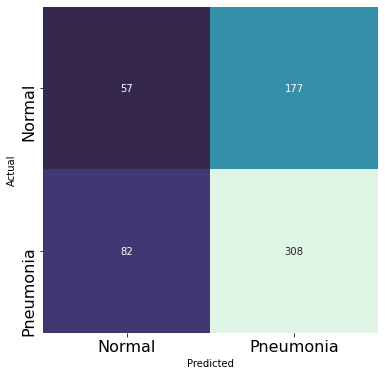

In [32]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [15]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [16]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [17]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.80
AUC: 0.94
Precision: 0.64
Recall: 0.79


# Data Every Day  

This notebook is featured on Data Every Day, a YouTube series where I train models on a new dataset each day.  

***

Check it out!  
https://youtu.be/xgRxO9iqITI